# Training and Evaluating Machine Learning (SVM) Model

In [1]:
# Importing Modules
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap

In [2]:
# Metabolomics Raw Data
data = pd.read_csv("metabolomics_data.csv", index_col="SampleID")

# data.head()

In [3]:
# Feature matrix
X = data.drop(["class"], axis=1)

# Target labels
y =  data["class"]

# y.value_counts().plot.bar()

In [4]:
# KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Imputing X (Feature matrix)
imputed_X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [5]:
# ANOVA based feature selection (top 75 features)
selector = selector = SelectKBest(score_func=f_classif, k=50)  
selector.fit_transform(imputed_X, y)

# Get names of selected features
selected_feature_names = imputed_X.columns[selector.get_support()]

# Final feature matrix with selected features
final_X = imputed_X[selected_feature_names.to_list()]
final_X.head()

,xylose,uric acid,tocopherol alpha,threonic acid,taurine,tagatose,serine,salicylic acid,pyruvic acid,pyrophosphate,...,arabitol,alpha ketoglutaric acid,5-hydroxynorvaline NIST,2-ketoisocaproic acid,2-hydroxyvaleric acid,2-hydroxyglutaric acid,2-hydroxybutanoic acid,"2,3,5-trihydroxypyrazine NIST",1-monostearin,"1,5-anhydroglucitol"
0,1086.0,10300.0,3184.0,5799.0,3628.0,1801.0,13130.0,178907.0,259.0,473.0,...,30.0,86.8,1065.0,708.0,926.0,979.0,1816.0,49.0,95.6,10561.0
1,471.0,20267.0,1886.4,941.0,655.0,859.0,4988.0,344.0,388.0,595.0,...,49.0,99.0,86.0,2510.0,648.0,201.0,8011.6,45.0,69.0,7300.0
2,305.0,22176.0,861.0,545.0,3445.4,380.0,20589.0,23667.0,1595.0,520.0,...,242.0,156.0,908.0,2395.0,596.0,686.0,4401.0,47.4,43.8,8860.0
3,646.0,10940.0,590.0,2991.0,3460.0,350.0,26701.0,2878.6,1097.0,528.0,...,164.0,170.0,376.0,1774.0,746.0,538.0,18331.0,57.0,47.0,9964.0
4,120.0,17165.0,609.0,681.0,2992.0,446.0,11464.0,505.0,2658.0,2340.0,...,155.0,320.0,372.0,3080.0,886.0,229.0,8135.0,159.0,49.0,14552.4


In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size=0.15, random_state=42, stratify=y)

# X_train.describe()
# X_train["serine"].hist()

In [7]:
# SMOTE oversampling (Training set)
os = SMOTE(random_state=42)
X_train, y_train = os.fit_resample(X_train, y_train)

# y_train.value_counts().plot.bar()

In [8]:
# Scaler
scaler = StandardScaler()

# Scaling training and test feature matrix
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# X_train.describe()
# X_train["serine"].hist()

In [9]:
# Model
model = SVC(random_state=42, probability=True)

In [10]:
# Model training
model = model.fit(X_train, y_train)

In [11]:
# Model testing
y_pred = model.predict(X_test)

In [12]:
# Classification report
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Adenocarcinoma       0.78      0.67      0.72        27
       Healthy       0.62      0.75      0.68        20

      accuracy                           0.70        47
     macro avg       0.70      0.71      0.70        47
  weighted avg       0.72      0.70      0.70        47



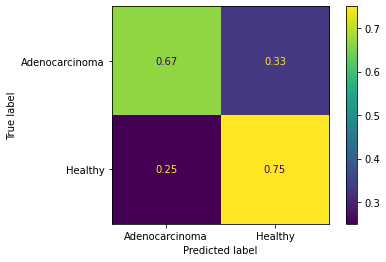

In [13]:
# Confusion matrix
cmat = confusion_matrix(y_test, y_pred, labels=model.classes_, normalize="true")
disp_cmat = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=model.classes_)
disp_cmat.plot()
plt.show()

In [14]:
# Shap analysis
shap.initjs()
X_temp = shap.sample(X_train, 50)
explainer = shap.KernelExplainer(model.predict_proba, X_temp)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/47 [00:00<?, ?it/s]

Shap Summary for Adenocarcinoma


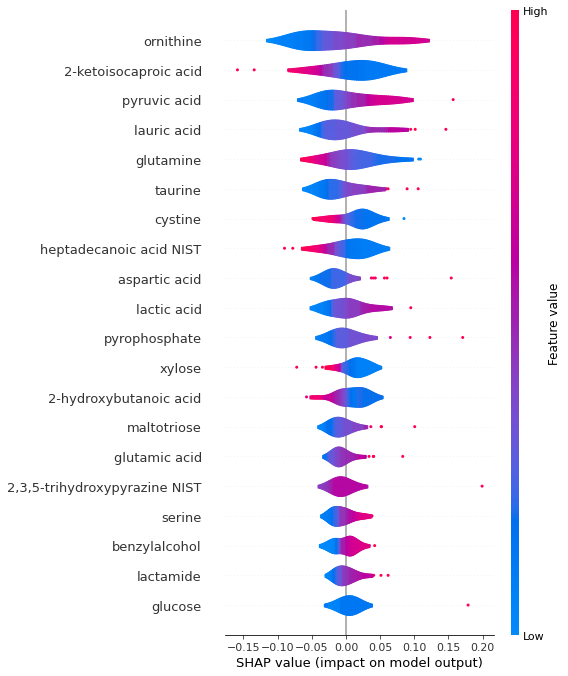

Shap Summary for Healthy


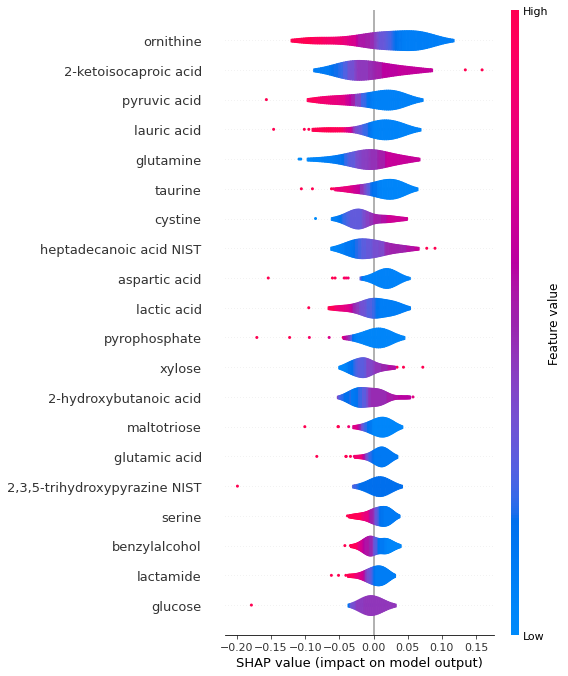

In [15]:
# Shap plot for Adenocarcinoma
print(f"Shap Summary for {model.classes_[0]}")
shap.summary_plot(shap_values[0], X_test, max_display=20, plot_type="violin")

# Shap plot for Healthy
print(f"Shap Summary for {model.classes_[1]}")
shap.summary_plot(shap_values[1], X_test, max_display=20, plot_type="violin")